In [2]:
import numpy as np
import pandas as pd

In [69]:
import matplotlib.pyplot as plt

### Import dataset

In [3]:
df_raw = pd.read_csv('./data/gemini_BTCUSD_2020_1min.csv')
df_raw.head(5)

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1.618880e+12,4/20/2021 0:02,BTCUSD,55717.47,55723.00,55541.69,55541.69,2.406734
1,1.618880e+12,4/20/2021 0:01,BTCUSD,55768.94,55849.82,55711.74,55717.47,0.573458
2,1.618880e+12,4/20/2021 0:00,BTCUSD,55691.79,55793.15,55691.79,55768.94,3.309904
3,1.618880e+12,4/19/2021 23:59,BTCUSD,55777.86,55777.86,55677.92,55691.79,0.684934
4,1.618880e+12,4/19/2021 23:58,BTCUSD,55803.50,55823.88,55773.08,55777.86,0.477225


### Pre-processing

In [4]:
print(df_raw.shape)
print(df_raw.isnull().sum())
df = df_raw

(658065, 8)
Unix Timestamp    0
Date              0
Symbol            0
Open              0
High              0
Low               0
Close             0
Volume            0
dtype: int64


##### Basic stats and correlation

In [5]:
all_columns = df.columns
print(f'All columns: {all_columns}')

unwanted_columns = ['Unix Timestamp', 'Date', 'Symbol']
feature_columns = [col for col in all_columns if col not in unwanted_columns]
print(f'Feature Columns: {feature_columns}')

df.loc[:, feature_columns].describe()

All columns: Index(['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')
Feature Columns: ['Open', 'High', 'Low', 'Close', 'Volume']


,Open,High,Low,Close,Volume
count,658065.000000,658065.000000,658065.000000,658065.000000,658065.000000
mean,19816.056864,19828.754551,19803.078994,19816.127876,1.552492
std,16737.625576,16750.786597,16723.509939,16737.677688,6.235548
min,3935.290000,3939.260000,3901.250000,3935.290000,0.000000
25%,9177.940000,9180.000000,9176.310000,9177.940000,0.022162
50%,10936.110000,10939.210000,10932.980000,10936.150000,0.189712
75%,25741.490000,25755.150000,25724.100000,25743.160000,1.023481
max,64890.000000,64900.000000,64775.620000,64890.000000,1043.579964


In [6]:
df_corr = df.loc[:, feature_columns].corr()
df_corr.style.applymap(lambda x: 'background-color: yellow' if x > 0.7 else '')

,Open,High,Low,Close,Volume
Open,1.000000,0.999999,0.999998,0.999998,-0.000244
High,0.999999,1.000000,0.999998,0.999999,0.000050
Low,0.999998,0.999998,1.000000,0.999999,-0.000691
Close,0.999998,0.999999,0.999999,1.000000,-0.000327
Volume,-0.000244,0.000050,-0.000691,-0.000327,1.000000


<AxesSubplot:xlabel='Date'>

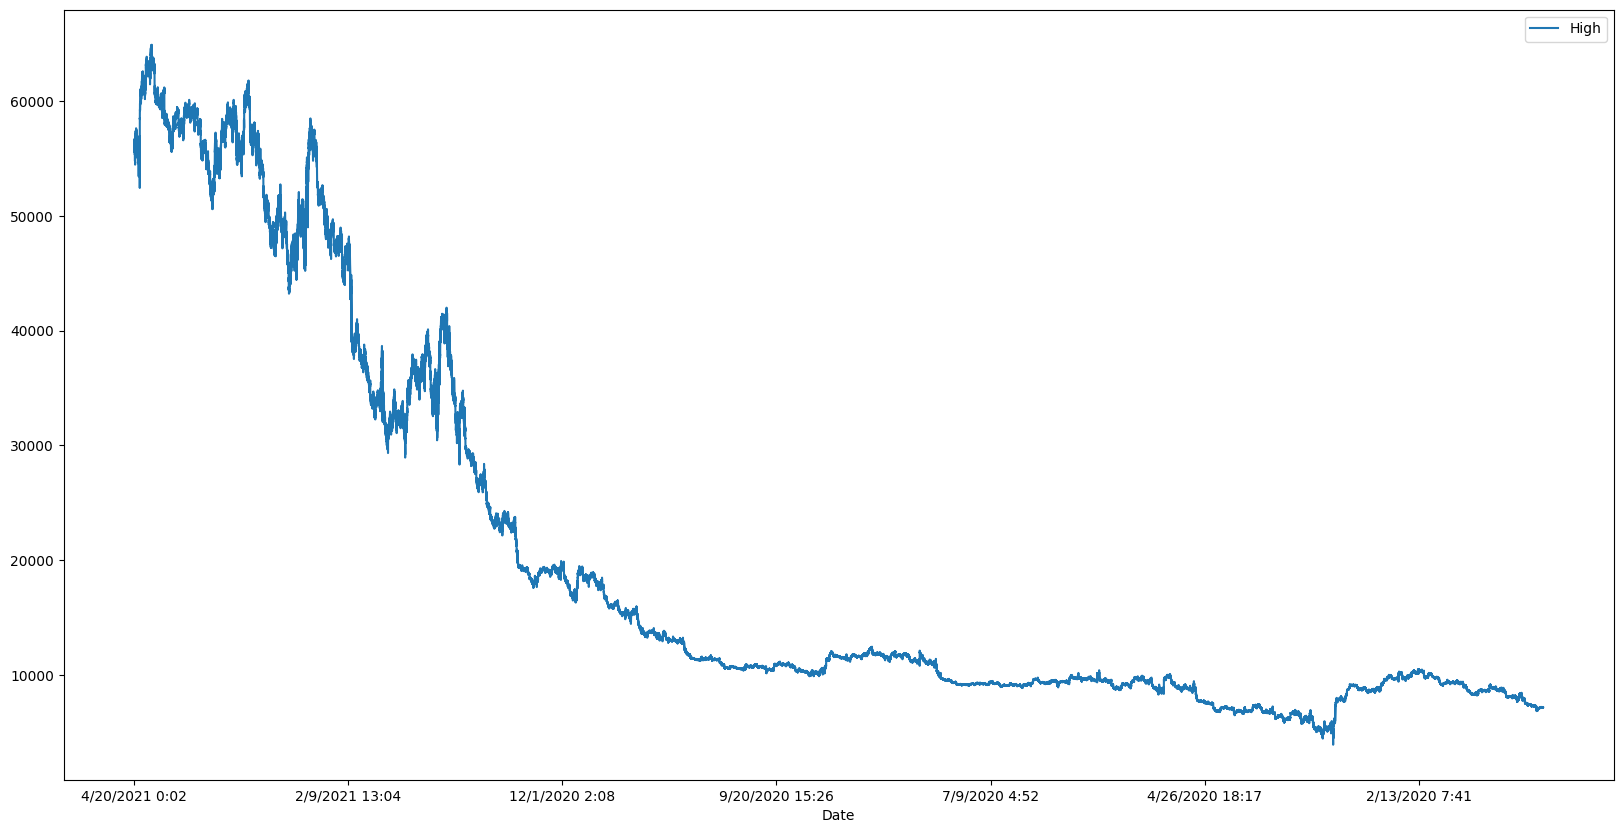

In [7]:
df.plot.line(x='Date', y='High', figsize=(20, 10))

### Use 'High' as endogenous variable

##### Convert date to datetime index and resample data to daily mean

In [18]:
df_high = df.loc[:, ['Date', 'High']]
print(df_high.dtypes)

df_high['Date'] = pd.to_datetime(df_high['Date'])
(print(df_high.dtypes))

Date     object
High    float64
dtype: object


In [ ]:
df_high.set_index('Date', inplace=True)

df_high_daily = df_high.resample('D').mean()
df_high_daily.head()

<AxesSubplot:xlabel='Date'>

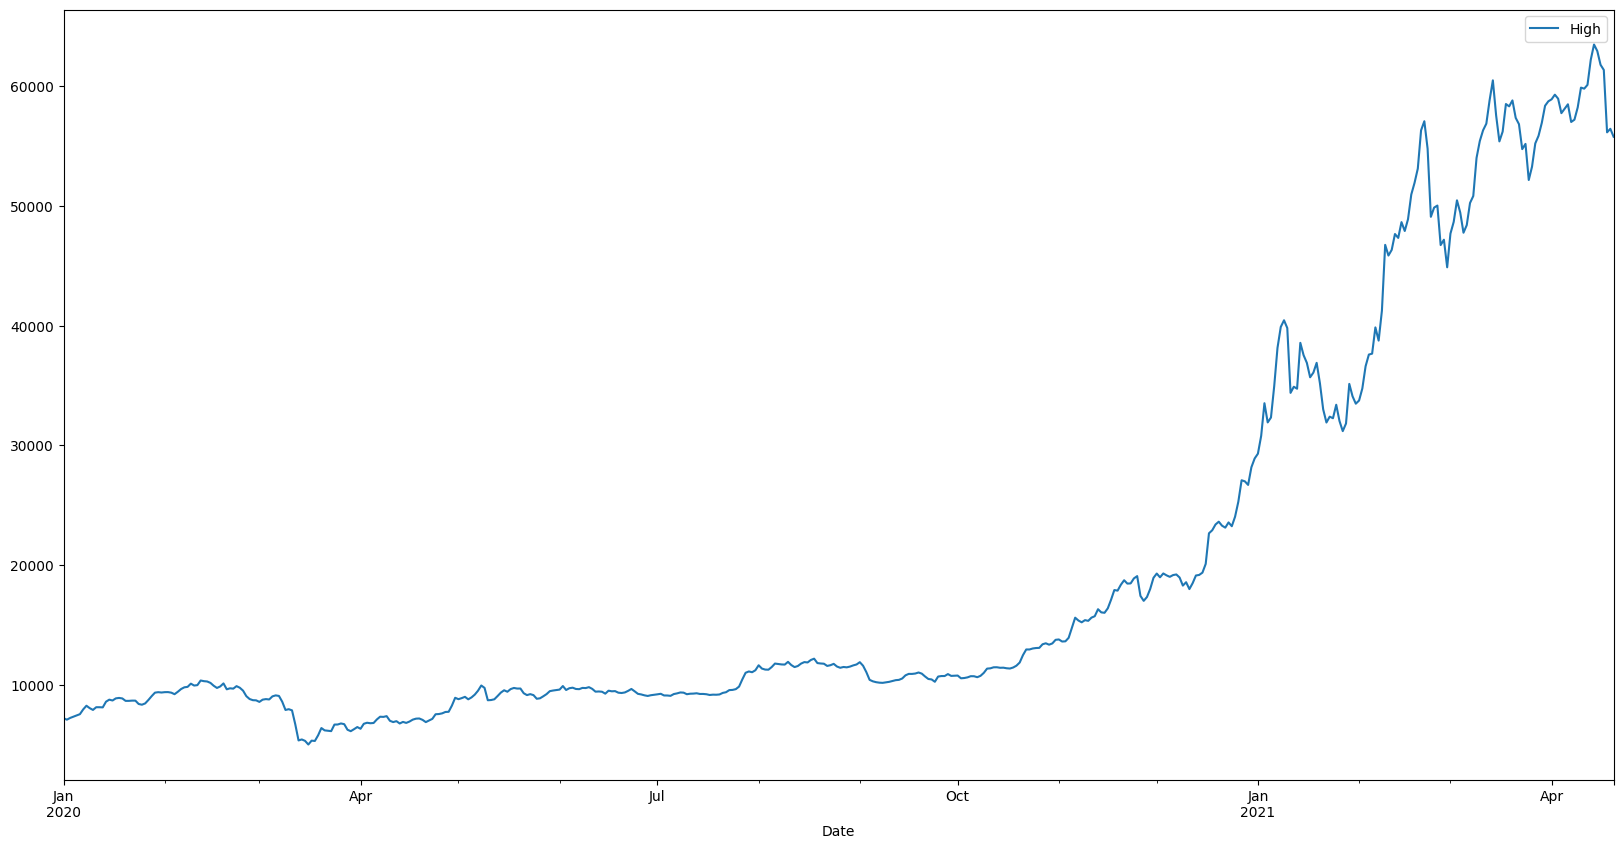

In [23]:
df_high_daily.plot.line(figsize=(20, 10))

### Split into train-test sets

In [96]:
total = df_high_daily.shape[0]
n = df_high_daily.shape[0] // 10

df_population = df_high_daily.copy()

df_test = df_population.iloc[-n:]
df_train = df_population.iloc[:(total-n)]

print(f'Train size: {df_train.shape}')
print(f'Test size: {df_test.shape}')

Train size: (429, 1)
Test size: (47, 1)


### Use Statsmodels to do fit an ARIMA model, as PyCaret Time-Series model had package dependency issues

In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

Finding 'd' factor .

Use AD Fuller to determine if differencing is needed. 

In [57]:
result = adfuller(df_high_daily['High'])
print(f'p-value: {result[1]}')


p-value: 0.9971259474134836


Since p-value is insignificant we decide to difference the dataset.

##### We use the ACF plot to determine 'd'.

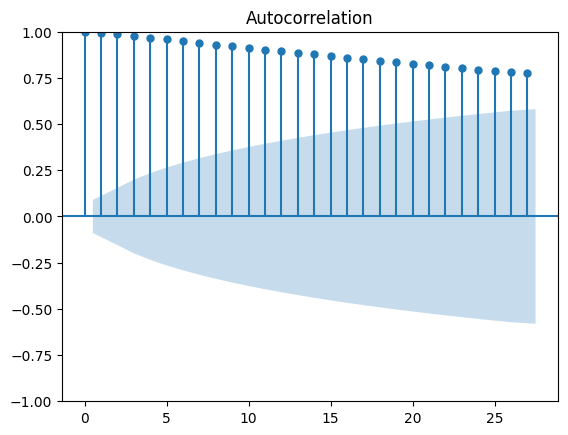

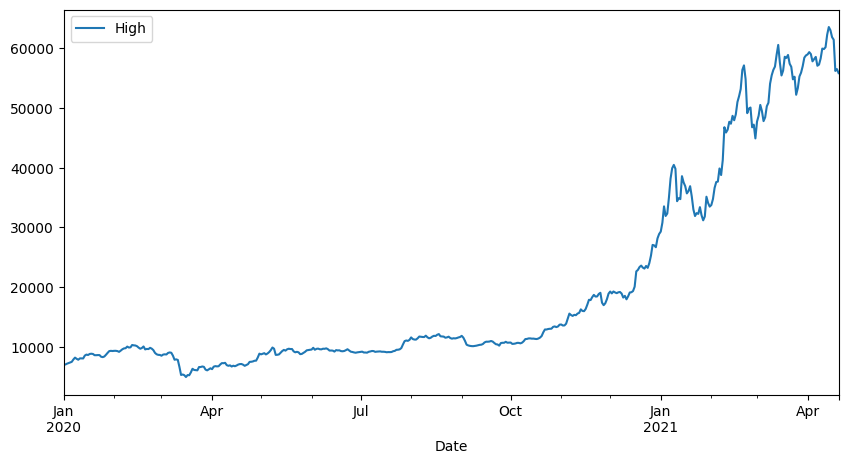

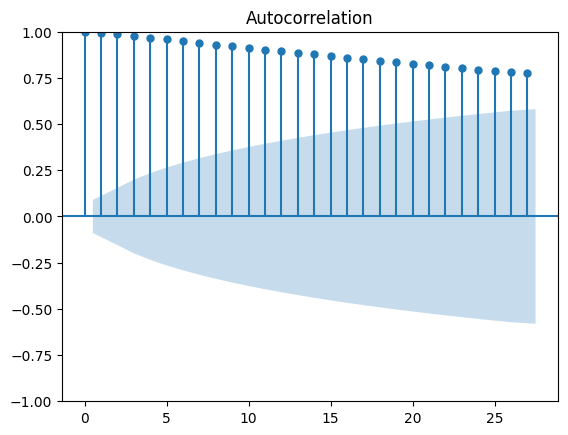

In [58]:
df_high_daily.plot.line(figsize=(10, 5))
plot_acf(df_high_daily['High'])

##### First difference

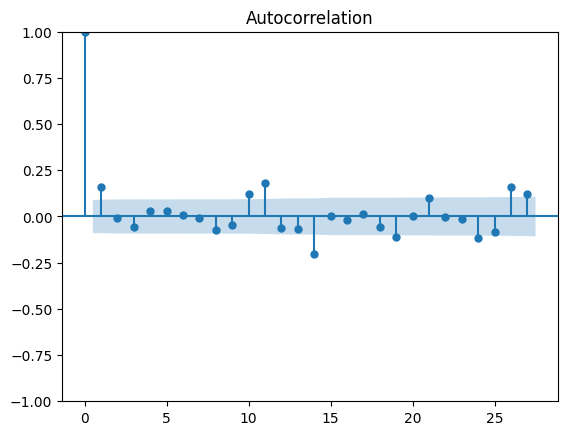

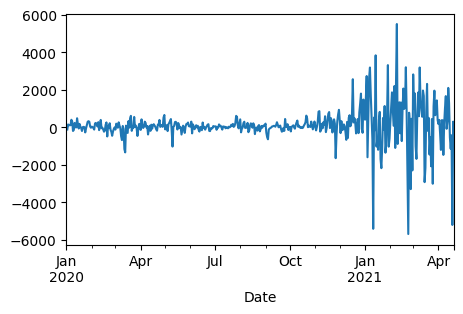

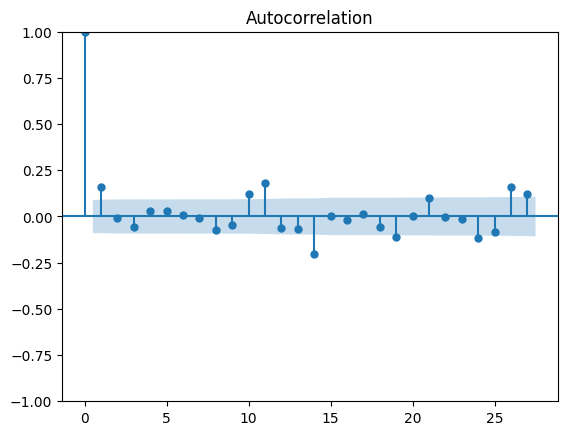

In [34]:
df_high_daily['High'].diff().plot.line(figsize=(5, 3))
plot_acf(df_high_daily['High'].diff().dropna())

##### Second difference

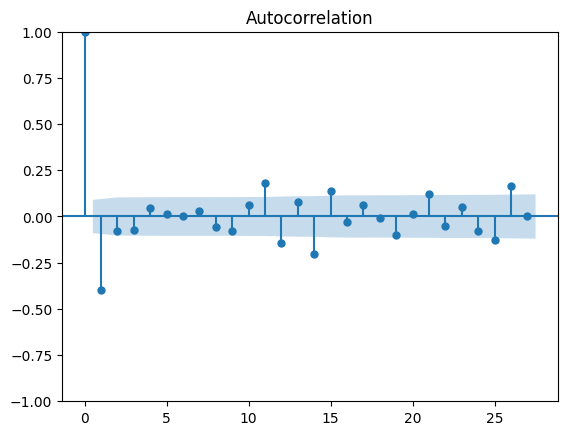

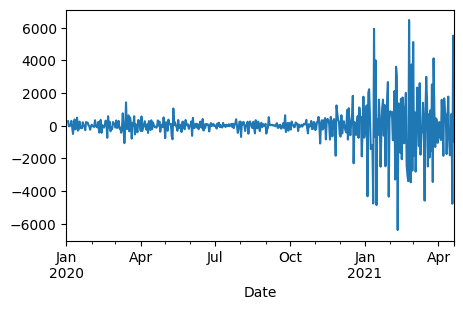

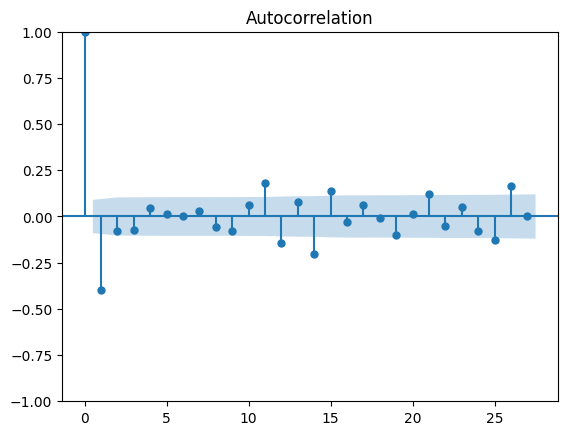

In [35]:
df_high_daily['High'].diff().diff().plot.line(figsize=(5, 3))
plot_acf(df_high_daily['High'].diff().diff().dropna())

We'll take d=1 as the second difference acf plot goes really negative quickly.
 
##### Next, well try to get the 'p' factor for the 'AR' part of the model using the PACF plot

/home/shernee/.virtualenvs/pycalpha/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


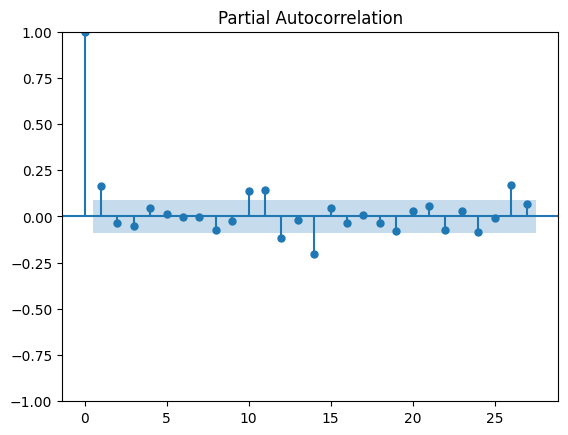

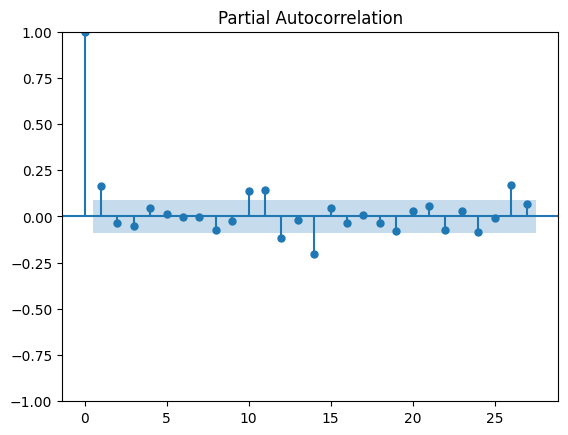

In [36]:
plot_pacf(df_high_daily['High'].diff().dropna())

We'll pick 'p' to be 1 as it crosses the significance line.

##### Finally we look for the 'q' term for the 'MA' portion of the model. For this we again look to the ACF plot.

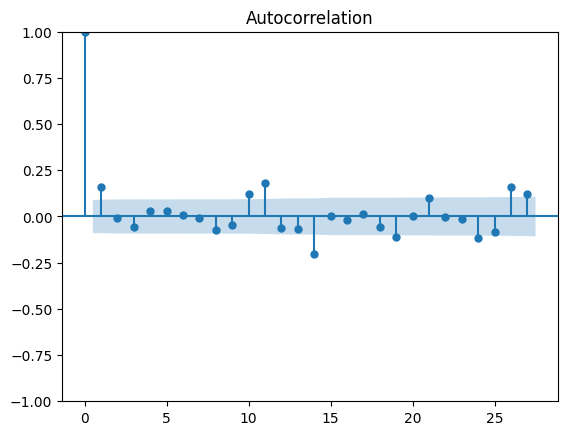

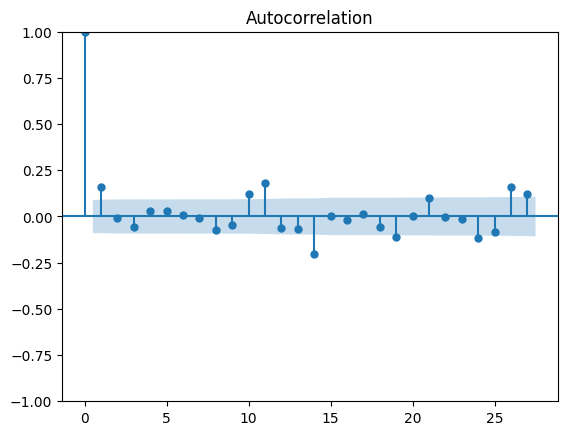

In [37]:
plot_acf(df_high_daily['High'].diff().dropna())

We select 'q' to be 1

##### We fit an ARIMA 1,1,1 model

In [59]:
model = ARIMA(df_train['High'], order=(1, 1, 1))
fitted_model = model.fit()

In [60]:
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                  429
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3475.066
Date:                Thu, 08 Sep 2022   AIC                           6956.132
Time:                        10:03:01   BIC                           6968.309
Sample:                    01-01-2020   HQIC                          6960.941
                         - 03-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0457      0.188      0.243      0.808      -0.323       0.415
ma.L1          0.1126      0.186      0.606      0.544      -0.251       0.476
sigma2      6.658e+05   1.74e+04     38.338      0.000    6.32e+05       7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4339.74
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              24.53   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### Since the AR1 term p-value is quite high (insignificant), we will refit the model with AR0

In [61]:
model = ARIMA(df_train['High'], order=(0, 1, 1))
fitted_model = model.fit()
fitted_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                  429
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -3475.085
Date:                Thu, 08 Sep 2022   AIC                           6954.171
Time:                        10:03:27   BIC                           6962.289
Sample:                    01-01-2020   HQIC                          6957.377
                         - 03-04-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1564      0.024      6.577      0.000       0.110       0.203
sigma2      6.658e+05   1.73e+04     38.430      0.000    6.32e+05       7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              4345.94
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):              24.54   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The AIC has reduced and also the AR1 term has an improved p-value

##### Predict

In [88]:
predictions = fitted_model.predict(start=0, end=total)

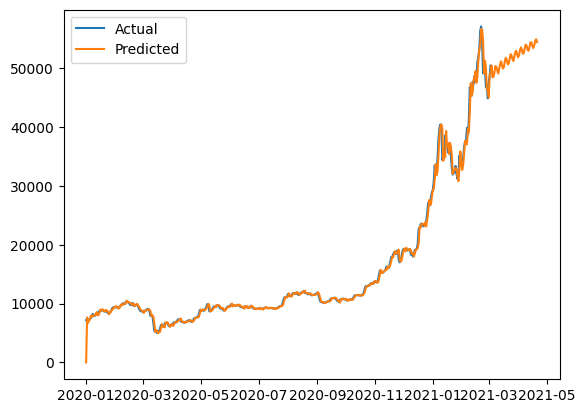

In [100]:
plt.plot(df_train['High'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.legend(loc='upper left')